Using device: cuda


Training Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0, Total Reward: -52735.14608095969, Path Length: 300
Episode 100, Total Reward: -2826.8443055057487, Path Length: 300
Episode 200, Total Reward: -81.44383691148136, Path Length: 300
Episode 300, Total Reward: -309.65048115088325, Path Length: 300
Episode 400, Total Reward: -362.1059017252397, Path Length: 300
Episode 500, Total Reward: -1202.5768139636502, Path Length: 300
Episode 600, Total Reward: -119.59812144121834, Path Length: 300
Episode 700, Total Reward: -912.5709017399734, Path Length: 300
Episode 800, Total Reward: -368.7156493785247, Path Length: 300
Episode 900, Total Reward: -363.02024885446747, Path Length: 300


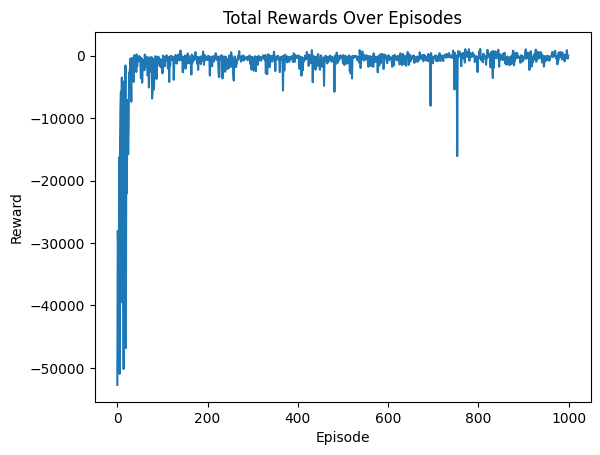

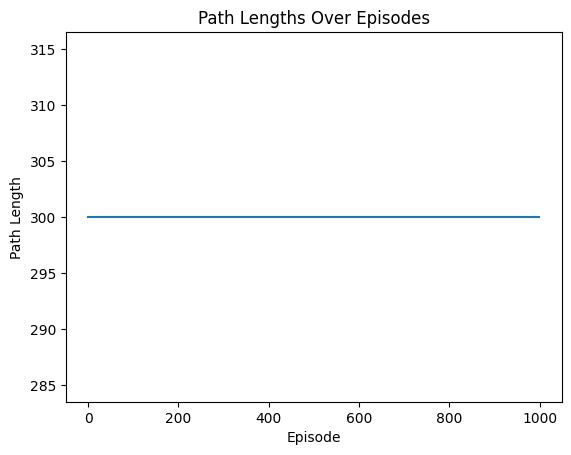

모델이 성공적으로 로드되었습니다.


C:\baramproject\sibal\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\baramproject\sibal\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\baramproject\sibal\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50756 (\N{HANGUL SYLLABLE WAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\baramproject\sibal\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\baramproject\sibal\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ba

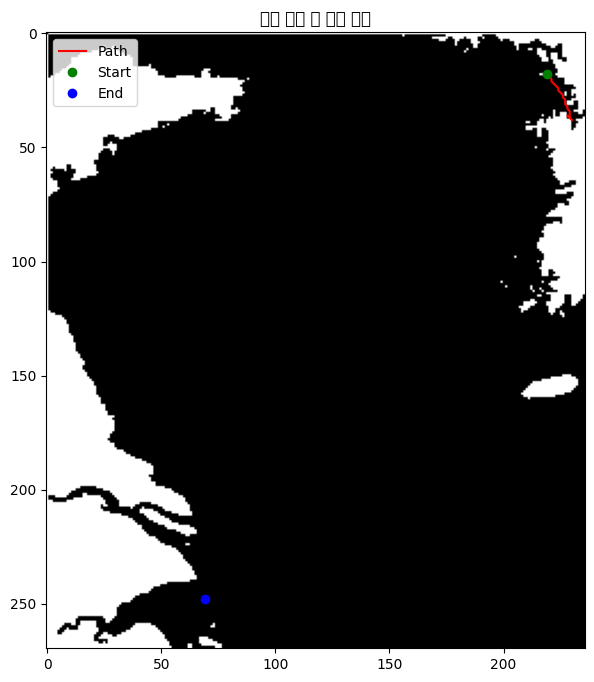

In [2]:
import numpy as np
from numba import jit, float64, int64, boolean
from datetime import datetime, timedelta
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# CUDA 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 경험 저장을 위한 named tuple 정의
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

# Dueling DQN 네트워크 정의
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.value_stream = nn.Linear(64, 1)
        self.advantage_stream = nn.Linear(64, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

# SumTree 클래스
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0
        self.n_entries = 0

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        self.write = (self.write + 1) % self.capacity
        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        while idx != 0:
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get(self, s):
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                break
            if s <= self.tree[left]:
                idx = left
            else:
                s -= self.tree[left]
                idx = right
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]

    def total(self):
        return self.tree[0]

# Numba로 최적화된 연료 소비 계산 함수
@jit(nopython=True)
def calculate_fuel_consumption(abs_action_angle, position, tidal_grid_dir, tidal_grid_speed, tidal_grid_valid, 
                               wind_grid_dir, wind_grid_speed, wind_grid_valid, k_w, n_rows, n_cols, f_0=1, V_s=6.68):
    row, col = position
    tidal_dir, tidal_speed = 0.0, 0.0
    if 0 <= row < n_rows and 0 <= col < n_cols and tidal_grid_valid[row, col]:
        tidal_dir = tidal_grid_dir[row, col]
        tidal_speed = tidal_grid_speed[row, col]
    wind_dir, wind_speed = 0.0, 0.0
    if 0 <= row < n_rows and 0 <= col < n_cols and wind_grid_valid[row, col]:
        wind_dir = wind_grid_dir[row, col]
        wind_speed = wind_grid_speed[row, col]
    
    tidal_dir_rad = (90.0 - tidal_dir) * np.pi / 180.0
    wind_dir_rad = (90.0 - wind_dir) * np.pi / 180.0
    action_angle_rad = (90.0 - abs_action_angle) * np.pi / 180.0
    
    theta_c = action_angle_rad - tidal_dir_rad
    theta_w = action_angle_rad - wind_dir_rad
    
    tidal_effect = (V_s - tidal_speed * np.cos(theta_c)) / V_s
    if tidal_effect <= 0:
        tidal_effect = 0.001
    
    fuel_tidal = f_0 * (tidal_effect ** 3)
    wind_effect = k_w * (wind_speed ** 2) * np.cos(theta_w)
    total_fuel = fuel_tidal + wind_effect
    return total_fuel

# Numba로 최적화된 거리 계산 함수
@jit(nopython=True)
def calculate_distance(end_pos, current_pos):
    rel_pos = end_pos - current_pos
    return np.linalg.norm(rel_pos)

# Numba로 최적화된 각도 계산 함수
@jit(nopython=True)
def calculate_angle(rel_pos):
    return (np.degrees(np.arctan2(rel_pos[1], -rel_pos[0])) % 360.0)

# Numba로 최적화된 그리드 방향 함수
@jit(nopython=True)
def angle_to_grid_direction(abs_action_angle, grid_angles):
    angle_diff = np.abs(grid_angles - abs_action_angle)
    closest_idx = np.argmin(angle_diff)
    return closest_idx

# 항해 환경 클래스
class NavigationEnv:
    def __init__(self):
        self.grid = np.load('land_sea_grid_cartopy_downsized.npy')
        self.n_rows, self.n_cols = self.grid.shape  # 270, 236
        self.lat_min, self.lat_max = 30.0, 38.0
        self.lon_min, self.lon_max = 120.0, 127.0
        self.start_pos = self.latlon_to_grid(37.46036, 126.52360)
        self.end_pos = self.latlon_to_grid(30.62828, 122.06400)
        self.step_time_minutes = 8.5
        self.max_steps = 300
        self.cumulative_time = 0
        self.step_count = 0
        self.tidal_data_dir = r"C:\baramproject\tidal_database_interpolated"
        self.wind_data_dir = r"C:\baramproject\wind_database_interpolated"
        self.action_space = np.array([-90, -45, 0, 45, 90], dtype=np.float64)
        self.current_direction = 0.0
        self.grid_directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
        self.grid_angles = np.array([0, 45, 90, 135, 180, 225, 270, 315], dtype=np.float64)
        self.k_w = 0.005
        self.f_0 = 1.0
        self.V_s = 6.68
        self.path = []
        self.tidal_cache = {}
        self.wind_cache = {}
        self.reset()

    def latlon_to_grid(self, lat, lon):
        row = int((self.lat_max - lat) / (self.lat_max - self.lat_min) * self.n_rows)
        col = int((lon - self.lon_min) / (self.lon_max - self.lon_min) * self.n_cols)
        return row, col

    def reset(self, start_time=None):
        start_date = datetime(2018, 1, 1, 0, 0)
        end_date = datetime(2018, 12, 29, 0, 0)
        if start_time is None:
            time_delta = (end_date - start_date).total_seconds()
            random_seconds = np.random.randint(0, int(time_delta / 60 / 30) + 1) * 30 * 60
            start_time = start_date + timedelta(seconds=random_seconds)
        
        self.current_pos = self.start_pos
        self.current_direction = 0.0
        self.visit_count = {}
        self.prev_action = None
        self.previous_direction = None
        self.current_time = start_time
        self.cumulative_time = 0
        self.load_tidal_data()
        self.map_tidal_to_grid()
        self.load_wind_data()
        self.map_wind_to_grid()
        self.prev_distance = self.get_distance_to_end()
        self.initial_distance = self.get_distance_to_end()
        self.step_count = 0
        self.path = []
        return self._get_state()

    def get_relative_position_and_angle(self):
        rel_pos = np.array(self.end_pos, dtype=np.float64) - np.array(self.current_pos, dtype=np.float64)
        distance = calculate_distance(np.array(self.end_pos, dtype=np.float64), np.array(self.current_pos, dtype=np.float64))
        end_angle = calculate_angle(rel_pos)
        return rel_pos, distance, end_angle

    def get_distance_to_end(self):
        return calculate_distance(np.array(self.end_pos, dtype=np.float64), np.array(self.current_pos, dtype=np.float64))

    def angle_to_grid_direction(self, abs_action_angle):
        closest_idx = angle_to_grid_direction(abs_action_angle, self.grid_angles)
        return self.grid_directions[closest_idx]

    def load_tidal_data(self):
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        dir_file = os.path.join(self.tidal_data_dir, f"tidal_dir_{time_str}.npy")
        speed_file = os.path.join(self.tidal_data_dir, f"tidal_speed_{time_str}.npy")
        
        if time_str in self.tidal_cache:
            self.tidal_data = self.tidal_cache[time_str]
        elif os.path.exists(dir_file) and os.path.exists(speed_file):
            grid_dir = np.load(dir_file)
            grid_speed = np.load(speed_file)
            self.tidal_data = {"dir": grid_dir, "speed": grid_speed}
            self.tidal_cache[time_str] = self.tidal_data
        else:
            print(f"Warning: Tidal data files for {time_str} not found.")
            self.tidal_data = None

    def map_tidal_to_grid(self):
        if self.tidal_data is not None:
            self.tidal_grid_dir = self.tidal_data["dir"]
            self.tidal_grid_speed = self.tidal_data["speed"]
            self.tidal_grid_valid = np.ones((self.n_rows, self.n_cols), dtype=np.bool_)
        else:
            self.tidal_grid_dir = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.tidal_grid_speed = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.tidal_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=np.bool_)

    def load_wind_data(self):
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        dir_file = os.path.join(self.wind_data_dir, f"wind_dir_{time_str}.npy")
        speed_file = os.path.join(self.wind_data_dir, f"wind_speed_{time_str}.npy")
        
        if time_str in self.wind_cache:
            self.wind_data = self.wind_cache[time_str]
        elif os.path.exists(dir_file) and os.path.exists(speed_file):
            grid_dir = np.load(dir_file)
            grid_speed = np.load(speed_file)
            self.wind_data = {"dir": grid_dir, "speed": grid_speed}
            self.wind_cache[time_str] = self.wind_data
        else:
            print(f"Warning: Wind data files for {time_str} not found.")
            self.wind_data = None

    def map_wind_to_grid(self):
        if self.wind_data is not None:
            self.wind_grid_dir = self.wind_data["dir"]
            self.wind_grid_speed = self.wind_data["speed"]
            self.wind_grid_valid = np.ones((self.n_rows, self.n_cols), dtype=np.bool_)
        else:
            self.wind_grid_dir = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.wind_grid_speed = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.wind_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=np.bool_)

    def step(self, action):
        self.step_count += 1
        rel_pos, distance, end_angle = self.get_relative_position_and_angle()
        rel_action_angle = self.action_space[action]
        abs_action_angle = (end_angle + rel_action_angle) % 360.0
        turn_penalty = 0.0
        if self.previous_direction is not None:
            angle_diff = min((abs_action_angle - self.previous_direction) % 360.0, 
                             (self.previous_direction - abs_action_angle) % 360.0)
            turn_penalty = angle_diff * 0.1
        move_dir = self.angle_to_grid_direction(abs_action_angle)
        new_pos = (self.current_pos[0] + move_dir[0], self.current_pos[1] + move_dir[1])
        
        current_fuel = calculate_fuel_consumption(abs_action_angle, self.current_pos, self.tidal_grid_dir, 
                                                  self.tidal_grid_speed, self.tidal_grid_valid, 
                                                  self.wind_grid_dir, self.wind_grid_speed, self.wind_grid_valid, 
                                                  self.k_w, self.n_rows, self.n_cols, self.f_0, self.V_s)
        
        if (0 <= new_pos[0] < self.n_rows and 0 <= new_pos[1] < self.n_cols and 
            self.grid[new_pos[0], new_pos[1]] == 0):
            self.current_pos = new_pos
            self.path.append(self.current_pos)
        self.previous_direction = abs_action_angle
        self.prev_action = action
        
        self.cumulative_time += self.step_time_minutes
        if self.cumulative_time >= 30:
            next_time = self.current_time + timedelta(minutes=30)
            end_date = datetime(2018, 12, 31, 23, 30)
            if next_time <= end_date:
                self.current_time = next_time
                self.load_tidal_data()
                if self.tidal_data is None:
                    print(f"No tidal data for {self.current_time}. Terminating episode.")
                    return self._get_state(), -1000, True, {}
                self.map_tidal_to_grid()
                self.load_wind_data()
                if self.wind_data is None:
                    print(f"No wind data for {self.current_time}. Terminating episode.")
                    return self._get_state(), -1000, True, {}
                self.map_wind_to_grid()
            else:
                print("Warning: Time exceeds 2018 range. Terminating episode.")
                return self._get_state(), -1000, True, {}
            self.cumulative_time -= 30
        
        state = self._get_state()
        current_distance = self.get_distance_to_end()
        
        # 두 가지 distance_reward 결합
        distance_reward = 0.0
        if self.initial_distance > 0:  # 초기 거리가 0이 아닌 경우
            # 선형 함수 기반 보상
            linear_reward = (1 - current_distance / self.initial_distance) * 10.0  # beta = 10.0
            # 변화량 기반 보상
            change_reward = (self.prev_distance - current_distance) * 2.0  # alpha = 2.0
            # 결합
            distance_reward = linear_reward + change_reward
        else:
            distance_reward = 0.0  # 초기 거리가 0인 경우 (이미 목표에 있는 경우)
        
        self.prev_distance = current_distance
        goal_reward = 100.0 if tuple(self.current_pos) == self.end_pos else 0.0
        reward = -current_fuel * 0.8 + distance_reward - turn_penalty + goal_reward
        done = tuple(self.current_pos) == self.end_pos or self.step_count >= self.max_steps
        return state, reward, done, {}

    def _get_state(self):
        row, col = self.current_pos
        state = []
        
        # 3x3 그리드 주변 정보 수집
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                r = row + dr
                c = col + dc
                if 0 <= r < self.n_rows and 0 <= c < self.n_cols:
                    # 맵 정보 (0: 바다, 1: 육지)
                    map_info = self.grid[r, c]
                    # 조류 정보
                    tidal_speed = self.tidal_grid_speed[r, c] if self.tidal_grid_valid[r, c] else 0.0
                    tidal_dir = self.tidal_grid_dir[r, c] if self.tidal_grid_valid[r, c] else 0.0
                    # 바람 정보
                    wind_speed = self.wind_grid_speed[r, c] if self.wind_grid_valid[r, c] else 0.0
                    wind_dir = self.wind_grid_dir[r, c] if self.wind_grid_valid[r, c] else 0.0
                    # 종료점까지의 거리
                    distance_to_end = calculate_distance(np.array(self.end_pos, dtype=np.float64), 
                                                        np.array([r, c], dtype=np.float64))
                else:
                    # 경계 밖은 육지로 간주
                    map_info = 1.0
                    tidal_speed = 0.0
                    tidal_dir = 0.0
                    wind_speed = 0.0
                    wind_dir = 0.0
                    distance_to_end = 0.0
                
                # 각 칸의 정보를 상태 벡터에 추가
                state.extend([map_info, tidal_speed, tidal_dir, wind_speed, wind_dir, distance_to_end])
        
        return np.array(state, dtype=np.float64)

# DQN 에이전트 클래스
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = 0.0001
        self.gamma = 0.99
        self.batch_size = 64
        self.buffer_size = 100000
        self.target_update = 1000
        self.epsilon_start = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 10000
        self.n_steps = 3
        self.alpha = 0.6
        self.beta_start = 0.4
        self.beta_end = 1.0
        self.beta_steps = 50000
        self.policy_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = SumTree(self.buffer_size)
        self.step_count = 0
        self.memory_counter = 0
        
    def select_action(self, state, epsilon):
        self.step_count += 1
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        max_priority = np.max(self.memory.tree[-self.memory.capacity:]) if self.memory.n_entries > 0 else 1.0
        self.memory.add(max_priority, experience)
        self.memory_counter += 1

    def sample_batch(self, beta):
        batch = []
        idxs = []
        priorities = []
        segment = self.memory.total() / self.batch_size
        for i in range(self.batch_size):
            a, b = segment * i, segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.memory.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)
        sampling_probabilities = np.array(priorities) / self.memory.total()
        weights = (self.memory.n_entries * sampling_probabilities) ** (-beta)
        weights /= weights.max()
        return batch, idxs, torch.FloatTensor(weights).to(device)

    def compute_n_step_target(self, batch, idxs):
        batch_size = len(batch)
        states = torch.FloatTensor(np.array([e.state for e in batch])).to(device)
        actions = torch.LongTensor([e.action for e in batch]).to(device)
        rewards = torch.FloatTensor([e.reward for e in batch]).to(device)
        next_states = torch.FloatTensor(np.array([e.next_state for e in batch])).to(device)
        dones = torch.FloatTensor([e.done for e in batch]).to(device)
    
        targets = rewards.clone()
        for i in range(1, self.n_steps):
            future_idxs = [idx + i for idx in idxs if idx + i < self.memory_counter]
            if future_idxs:
                future_batch = []
                valid_future_idxs = []
                for idx in future_idxs:
                    if idx < self.memory.n_entries + self.memory.capacity - 1:
                        future_batch.append(self.memory.data[idx % self.memory.capacity])
                        valid_future_idxs.append(idx)
                
                if len(future_batch) > 0:
                    future_rewards = torch.FloatTensor([e.reward for e in future_batch]).to(device)
                    future_dones = torch.FloatTensor([e.done for e in future_batch]).to(device)
                    mask = torch.zeros(batch_size, dtype=torch.bool, device=device)
                    mask[:len(valid_future_idxs)] = True
                    targets[mask] += (self.gamma ** i) * future_rewards[:len(valid_future_idxs)] * (1 - future_dones[:len(valid_future_idxs)])
    
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            target_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            targets += (self.gamma ** self.n_steps) * target_q * (1 - dones)
    
        return states, actions, targets

    def compute_loss(self, batch, idxs, weights):
        if not batch:
            return torch.tensor(0.0, device=device, requires_grad=True)
        
        states, actions, targets = self.compute_n_step_target(batch, idxs)
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        td_errors = (q_values.detach() - targets).cpu().numpy()
        loss = (weights * (q_values - targets) ** 2).mean()
        for idx, td_error in zip(idxs, td_errors):
            priority = (abs(td_error) + 0.01) ** self.alpha
            self.memory.update(idx, priority)
        return loss

    def update(self):
        if self.memory.n_entries < self.batch_size + self.n_steps - 1:
            return
        beta = self.beta_start + (self.beta_end - self.beta_start) * min(1.0, self.step_count / self.beta_steps)
        batch, idxs, weights = self.sample_batch(beta)
        loss = self.compute_loss(batch, idxs, weights)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

# 학습 루프 정의
def train_dqn(env, agent, max_episodes=1000):
    rewards = []
    path_lengths = []
    epsilon = agent.epsilon_start
    image_dir = r"C:\baramproject\trained_model\new_sibal8\episode_debug_image"
    data_dir = r"C:\baramproject\trained_model\new_sibal8\episode_debug_data"
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)
    
    for episode in tqdm(range(max_episodes), desc="Training Episodes"):
        state = env.reset()
        total_reward = 0
        path_length = 0
        done = False
        debug_mode = episode % 500 == 0
        debug_data = [] if debug_mode else None
        
        while not done:
            epsilon = max(agent.epsilon_end, epsilon - (agent.epsilon_start - agent.epsilon_end) / agent.epsilon_decay)
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            q_values = agent.policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).detach().cpu().numpy().flatten()
            if debug_mode:
                debug_data.append({
                    "step": path_length,
                    "state": state.tolist(),
                    "action": action,
                    "reward": reward,
                    "next_state": next_state.tolist(),
                    "q_values": q_values.tolist(),
                    "epsilon": epsilon
                })
            agent.store_experience(state, action, reward, next_state, done)
            if path_length % 4 == 0:
                agent.update()
            state = next_state
            total_reward += reward
            path_length += 1
        
        rewards.append(total_reward)
        path_lengths.append(path_length)

        if debug_mode:
            with open(os.path.join(data_dir, f"episode_{episode}.json"), 'w') as f:
                json.dump(debug_data, f, indent=4)
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Path Length: {path_length}")
            plt.figure(figsize=(10, 8))
            plt.imshow(env.grid, cmap='gray')
            path_array = np.array(env.path)
            plt.plot(path_array[:, 1], path_array[:, 0], 'r-', label='Path')
            plt.plot(env.start_pos[1], env.start_pos[0], 'go', label='Start')
            plt.plot(env.end_pos[1], env.end_pos[0], 'bo', label='End')
            plt.legend()
            plt.title(f"Episode {episode} Path")
            plt.savefig(os.path.join(image_dir, f"episode_{episode}.png"))
            plt.close()
    
    torch.save(agent.policy_net.state_dict(), r"C:\baramproject\trained_model\new_sibal8\navigation_model.pth")
    return rewards, path_lengths

# 메인 실행
if __name__ == "__main__":
    env = NavigationEnv()
    state_dim = 54  # 9 (맵) + 18 (조류) + 18 (바람) + 9 (거리)
    action_dim = len(env.action_space)
    agent = DQNAgent(state_dim, action_dim)
    
    # 학습 실행
    rewards, path_lengths = train_dqn(env, agent)
    
    # 학습 결과 그래프 출력
    plt.plot(rewards)
    plt.title("Total Rewards Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()
    plt.plot(path_lengths)
    plt.title("Path Lengths Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Path Length")
    plt.show()

    # 학습 완료 후 모델 로드 및 경로 탐색
    model_path = r"C:\baramproject\trained_model\new_sibal8\navigation_model.pth"
    if os.path.exists(model_path):
        agent.policy_net.load_state_dict(torch.load(model_path))
        agent.policy_net.eval()
        print("모델이 성공적으로 로드되었습니다.")
        
        # 경로 탐색
        state = env.reset()
        done = False
        path = [env.current_pos]  # 경로 기록 리스트
        while not done:
            action = agent.select_action(state, epsilon=0.0)  # 탐색 없이 최적 행동 선택
            next_state, _, done, _ = env.step(action)
            path.append(env.current_pos)
            state = next_state
        
        # 탐색된 경로 시각화
        plt.figure(figsize=(10, 8))
        plt.imshow(env.grid, cmap='gray')
        path_array = np.array(path)
        plt.plot(path_array[:, 1], path_array[:, 0], 'r-', label='Path')
        plt.plot(env.start_pos[1], env.start_pos[0], 'go', label='Start')
        plt.plot(env.end_pos[1], env.end_pos[0], 'bo', label='End')
        plt.legend()
        plt.title("Final Path")
        plt.show()
    else:
        print("모델 파일을 찾을 수 없습니다. 먼저 모델을 학습시켜 주세요.")